In [27]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [33]:
from sklearn.cross_validation import KFold
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

In [2]:
os.chdir('../')

In [3]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'

In [8]:
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [5]:
debiased_data = Table.read('../fits/' + full_sample)
print('Loaded galaxy data...')
in_volume_limit = debiased_data['in_volume_limit'] == True
in_mass_limit = debiased_data['LOGMSTAR_BALDRY06'] > 10.6
vl_data = debiased_data[(in_volume_limit)]
ml_data = debiased_data[(in_volume_limit) & (in_mass_limit)]

In [58]:
colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [15]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh_normalised'
    else:
        suffix = '_debiased_rh'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        select = np.ones(len(full_data)) == 1
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced,select


def get_spirals_and_assignments(full_data,question_dictionary,th=None):
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    
    answers = question_dictionary['t11_arms_number']['answers']

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    print('{} galaxies with p>0.5 and N>=5'.format(len(spirals)))
    
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers[:-1]]
    raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    if th != None:
        select = np.max(arm_array,axis=1) > th
    else:
        select = np.ones(len(spirals)) == 1
    
    arm_assignments = np.argmax(arm_array,axis=1)
    raw_assignments = np.argmax(raw_array,axis=1)
    
    arm_assignments = arm_assignments[select]
    raw_assignmnets = raw_assignments[select]
    spirals = spirals[select]
    redshifts = spirals['REDSHIFT_1']
    
    return spirals,arm_assignments

In [17]:
vl_spirals,vl_assignments = get_spirals_and_assignments(vl_data,questions)
ml_spirals,ml_assignments = get_spirals_and_assignments(ml_data,questions)

21591/62220 galaxies with p>0.5 and N>=5.
17953 galaxies with p>0.5 and N>=5
11218/41801 galaxies with p>0.5 and N>=5.
9389 galaxies with p>0.5 and N>=5


In [ ]:
colors = ['r','b','g','y']
colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [18]:
def preprocess_data(x,y,N_out=100,levels=[0.8,0.6,0.4,0.2],x_range=None,y_range=None,bandwidth='optimal'):
    
    values = np.array([x,y]).T # Read the x and y data into the correct format.
    
    # First set the x and y ranges if not done so already:
    if x_range == None:
        x_range = [np.min(values[:,0]),np.max(values[:,0])] 
    if y_range == None:
        y_range = [np.min(values[:,1]),np.max(values[:,1])]
        
    # Select values within the specified range:  
    values = values[(values[:,0] >= x_range[0]) & (values[:,0] <= x_range[1])
        & (values[:,1] >= y_range[0]) & (values[:,1] <= y_range[1])]
    
    # Scale the appropriate values:
    values_scaled = preprocessing.scale(values)
    x_range_scaled = [(x_r-np.mean(x))*(1/np.std(x)) for x_r in x_range]
    y_range_scaled = [(y_r-np.mean(y))*(1/np.std(y)) for y_r in y_range]
    
    return values_scaled,x_range_scaled,y_range_scaled

In [53]:
def contour(values,bandwidth,x,y,x_range,y_range,ax,colour='k',colmap='Greys',filled=False):
    
    values = values[(np.isfinite(values[x])) & (np.isfinite(values[y]))]
    
    v_scaled,x_scaled,y_scaled = preprocess_data(values[x],values[y],x_range=x_range,y_range=y_range)
    h,v = get_kde(v_scaled,x_scaled,y_scaled,bandwidth) # KDE from obtained bandwidths
    x = np.linspace(x_range[0],x_range[1],100)
    y = np.linspace(y_range[0],y_range[1],100)
    
    for ax1 in ax:
        if filled is True:
            ax1.contourf(x,y,h,levels=np.append(v,np.max(h)),cmap=colmap)
            ax1.contour(x,y,h,levels=v,linewidths=1,colors=colour)
        else:
            ax1.contour(x,y,h,levels=v,linewidths=2,colors=colour)
        
    return None

In [31]:
def get_kde_bandwidth(values,x_range=None,y_range=None,N=10,n_folds=5,num_sigmas=20,plot_values=False):
    
    if len(values) > 5000: # Try to speed up the process for large datasets. 
        # Will need to remove this when making final plots.
        np.random.shuffle(values)
        values = values[:5000]
                   
    params = {'bandwidth': np.logspace(-1,0.3,num_sigmas)}
    kf = KFold(n=len(values),n_folds=n_folds,shuffle=True)
    grid = GridSearchCV(KernelDensity(), params,cv=kf)
    grid.fit(values)
    
    if plot_values:
        gridscores = grid.grid_scores_
        sigmas = np.logspace(-1,0.3,num_sigmas)
        chisq = np.zeros((num_sigmas,1))
        for r in range(num_sigmas):
            chisq[r] = gridscores[r][1]
        plt.plot(sigmas,chisq)
        
    return grid.best_estimator_.bandwidth  

In [20]:
def get_kde(values,x_range,y_range,bandwidth,N_out=100,levels=[0.8,0.6,0.4,0.2]):  
    
    X = np.linspace(x_range[0],x_range[1],N_out+1)
    Y = np.linspace(y_range[0],y_range[1],N_out+1)
    xy = get_bins(N_out,x_range,y_range)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(values)
    H = np.exp(kde.score_samples(xy).reshape(N_out,N_out))
    # Rest is taken from the triangle.py method of plotting fractional data contours.
    #--------------------------------------------------------------------------------
    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    #--------------------------------------------------------------------------------
    return H,V

In [24]:
def get_bandwidth_list(full_table,spirals_table,assignments,
                       x,y,x_range,y_range,filename):
    
    '''x = column name for x axis
       y = column name for y axis
    '''

    start = time.clock()
    bandwidths = np.zeros(6)

    v_scaled,x_scaled,y_scaled = preprocess_data(full_table[x],full_table[y],x_range=x_range,y_range=y_range)
    bandwidths[0] = get_kde_bandwidth(values=v_scaled,x_range=x_scaled,y_range=y_scaled,plot_values=False)

    for m in range(5):
    
        spirals_m = spirals_table[assignments == m]
        v_scaled,x_scaled,y_scaled = preprocess_data(spirals_m[x],spirals_m[y],x_range=x_range,y_range=y_range)
        bandwidths[m+1] = get_kde_bandwidth(values=v_scaled,x_range=x_scaled,y_range=y_scaled,plot_values=False)
    
    print('{0:0.1f} seconds in total'.format(time.clock() - start)) # Time it took to plot all of this.
    
    np.save('npy/' + filename + '.npy',bandwidths)
    
    return bandwidths

In [22]:
def plot_bandwidth(x,y,ax,position,bandwidth,colour='k',linewidth=1,x_range=None,y_range=None):
    
    values = np.array([x,y]).T # Read the x and y data into the correct format.
    
    # First set the x and y ranges if not done so already:
    if x_range == None:
        x_range = [np.min(values[:,0]),np.max(values[:,0])] 
    if y_range == None:
        y_range = [np.min(values[:,1]),np.max(values[:,1])]
        
    # Select values within the specified range:  
    values = values[(values[:,0] >= x_range[0]) & (values[:,0] <= x_range[1])
        & (values[:,1] >= y_range[0]) & (values[:,1] <= y_range[1])]

    # Get axis positions
    x_axes = ax.get_xlim()
    y_axes = ax.get_ylim()
    x_pos = x_axes[0] + (x_axes[1]-x_axes[0])*position[0]
    y_pos = y_axes[0] + (y_axes[1]-y_axes[0])*position[1]
    
    # Now get scaled bandwidth:
    x_scaled_bw = bandwidth*np.std(values[:,0])
    y_scaled_bw = bandwidth*np.std(values[:,1])
    ax.hlines(y_pos,x_pos-x_scaled_bw,x_pos+x_scaled_bw,
              color=colour,linewidth=linewidth)
    ax.vlines(x_pos,y_pos-y_scaled_bw,y_pos+y_scaled_bw,
              color=colour,linewidth=linewidth)
    
    return None

In [45]:
def get_bins(N,x_range,y_range):

    bins_x = np.linspace(x_range[0],x_range[1],N+1)
    bins_y = np.linspace(y_range[0],y_range[1],N+1)
    
    bin_centres_x = np.array([bins_x[B] + (bins_x[B+1]-bins_x[B])/2 for B in range(N)])
    bin_centres_y = np.array([bins_y[B] + (bins_y[B+1]-bins_y[B])/2 for B in range(N)])
    
    xx_centres,yy_centres =  np.meshgrid(bin_centres_x,bin_centres_y)
    xy = np.array([np.ravel(xx_centres),np.ravel(yy_centres)]).T # Used to 'score' the samples.
    
    return xy

In [34]:
u_cm = get_bandwidth_list(ml_data,ml_spirals,ml_assignments,
                          x='LOGMSTAR_BALDRY06',y='sfr_total_avg',
                          x_range=[10,11.5],y_range=[-1.5,1.5],filename='cm')

75.9 seconds in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less_equal


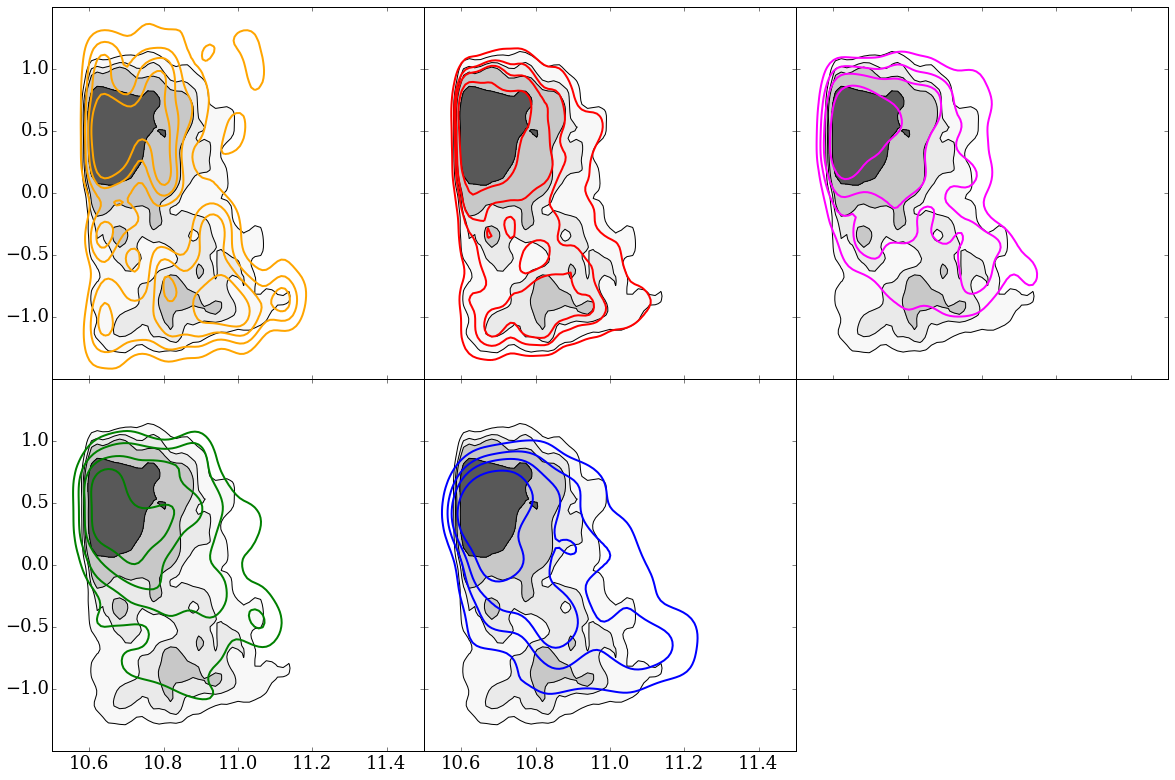

In [61]:
fig,axarr = plt.subplots(2,3,figsize=(20,20*(2/3)),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

#x_b = np.linspace(10.6,11.2,100)

#popt,pcov = curve_fit(line_full,spirals_cm1['x'],spirals_cm1['y'])
#k_full = popt[0]

x = 'LOGMSTAR_BALDRY06'
y = 'sfr_total_avg'

contour(ml_spirals,u_cm[0],x,y,x_range=[10,11.5],y_range=[-1.5,1.5],
        ax=axarr,filled=True)

axarr[0].set_xlim(10.5,11.5)

for m in range(5):
    
    spirals_m = ml_spirals[ml_assignments == m]
    
    contour(spirals_m,u_cm[m+1],x,y,x_range=[10.5,11.5],y_range=[-1.5,1.5],
            ax=[axarr[m]],colour=colors_long[m])
    
    #plot_bandwidth(spirals_m['x'],spirals_m['y'],axarr[m],[0.875,0.9],u_cm1[m+1],colour=clr[m],linewidth=2)
    #plot_bandwidth(table_cc['x'],table_cc['y'],axes[m],[0.875,0.8],u_cm1[0],linewidth=1)
    
    #popt,pcov = curve_fit(line, spirals_m['x'],spirals_m['y'],maxfev=10**4)
    #axes[m].plot(x_b,line(x_b,popt[0]),linewidth=2,linestyle='--',color=clr[m])
    #print(popt,pcov)
    
#plt.savefig('../../output_images/contours/colour_mass_1.pdf')